Face mask detection using MobileNetV2

## Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

### Let's view some of the images of **Train** Dataset

In [ ]:
data_train = image_dataset_from_directory(train_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_validation = image_dataset_from_directory(val_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_test = image_dataset_from_directory(test_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)


Found 10000 files belonging to 2 classes.


2022-09-26 07:52:36.978438: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


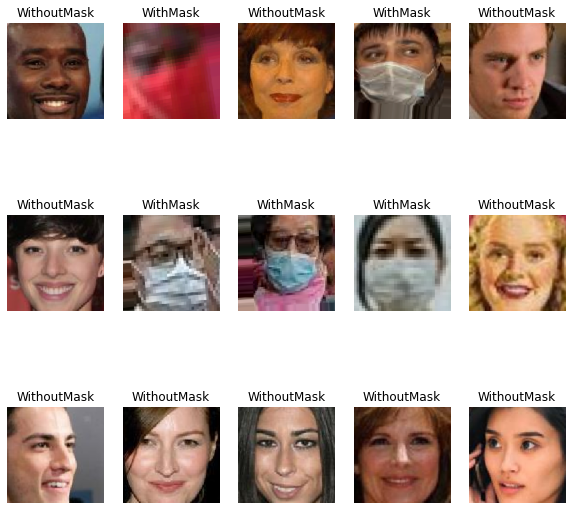

In [ ]:
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')


# from IPython.display import clear_output
clear_output()

## Data Augmentation

In [ ]:
# Image size
IMG_SIZE = (256, 256)

# data argumentation
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                       rotation_range=45,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True
                                       )

# data argumentation
test_datagen = ImageDataGenerator(rescale= 1 / 255.0)

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## MobileNetV2 Base Model

In [ ]:
# using mobilenetv2 model
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(256,256,3))
# make pre trained model into non trainable bcoz its takes much time
for layer in mobilenet.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


## Transfer Learning

In [ ]:
# Initialize the model in sequential
model = Sequential()
# add MobileNetV2 model into our sequence model
model.add(mobilenet)
# flatten the model
model.add(Flatten())
# Adding dense layers
model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
# Adding output layer
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10485888  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 12,744,130
Trainable params: 10,486,146
Non-trainable params: 2,257,984
_________________________________________________________________


### Defining Callbacks

In [ ]:
# # Defining Callbacks

# monitor = EarlyStopping(monitor='val_auc', patience=10,
#                         min_delta=1e-5,verbose=1, mode='max',restore_best_weights=True)

# filepath = './best_weights.h5'
# checkpoint    = ModelCheckpoint(filepath,
#                                 monitor = 'val_auc',
#                                 mode='max',
#                                 save_best_only=True,
#                                 save_weights_only=False,
#                                 verbose = 1)

# callbacks_list = [monitor, checkpoint]


## Compile the Model

In [ ]:
# model compile
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

## Model Fitting

In [ ]:
history = model.fit(train_dataset,
                              validation_data=validation_dataset,
                              epochs=5,
                              verbose=1)

Epoch 1/5
50/50 [==============================] - 346s 7s/step - loss: 3.3110 - accuracy: 0.6414 - val_loss: 0.4011 - val_accuracy: 0.9438
Epoch 2/5
50/50 [==============================] - 315s 6s/step - loss: 0.2170 - accuracy: 0.9488 - val_loss: 0.0921 - val_accuracy: 0.9675
Epoch 3/5
50/50 [==============================] - 316s 6s/step - loss: 0.0758 - accuracy: 0.9742 - val_loss: 0.0508 - val_accuracy: 0.9837
Epoch 4/5
50/50 [==============================] - 321s 6s/step - loss: 0.0466 - accuracy: 0.9856 - val_loss: 0.0404 - val_accuracy: 0.9837
Epoch 5/5
50/50 [==============================] - 316s 6s/step - loss: 0.0392 - accuracy: 0.9865 - val_loss: 0.0356 - val_accuracy: 0.9862


In [ ]:
model.evaluate(validation_dataset)

13/13 [==============================] - 24s 2s/step - loss: 0.0355 - accuracy: 0.9850


[0.03554710000753403, 0.9850000143051147]

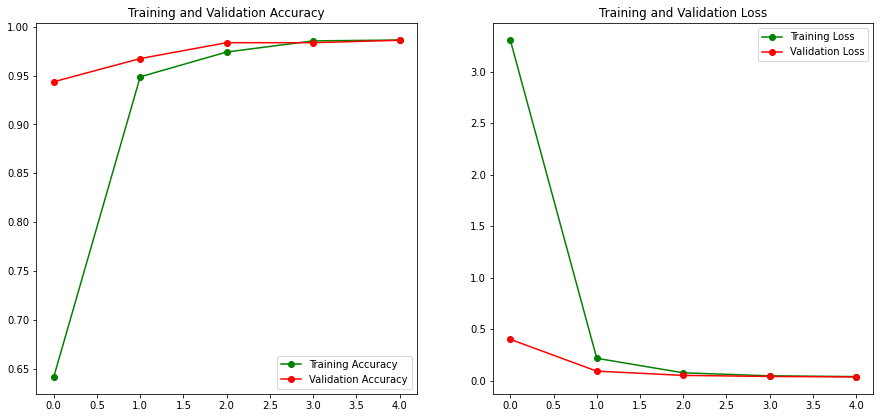

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,"go-", label='Training Accuracy')
plt.plot(epochs_range, val_acc,"ro-", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss,"go-", label='Training Loss')
plt.plot(epochs_range, val_loss,"ro-", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Prediction

In [ ]:
test_pred = model.predict(test_dataset)

In [ ]:
output = [np.argmax(op) for op in test_pred]
df_output = pd.DataFrame(output)
print(df_output.value_counts())

1    504
0    488
dtype: int64


In [ ]:
def img_preprocessing(path):
    sample_mask_img = cv2.imread(path)
    sample_mask_img = cv2.resize(sample_mask_img,(256,256))
    plt.imshow(sample_mask_img)
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    print('            ', colored(classes_train[res], "green"))

             WithoutMask


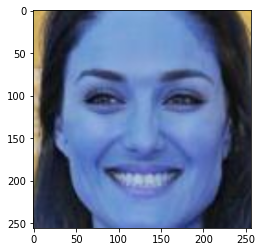

In [ ]:
img_preprocessing('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/1003.png')

             WithMask


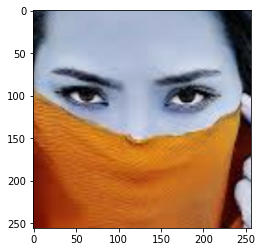

In [ ]:
img_preprocessing('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask/1003.png')